In [1]:
import numpy as np
from obspy import read, UTCDateTime, Stream, Trace, read_inventory
from obspy.clients.filesystem import sds
import matplotlib.pylab as plt
SDS_DATA_PATH = "/Users/jowa/Skience2026_DATA/data_sds/"

In [2]:
def raydec1station(vert, north, east, fmin, fmax, fsteps, cycles, dfpar, nwind):

# RAYDEC1STATION(VERT, NORTH, EAST, TIME, FMIN, FMAX, FSTEPS, CYCLES, DFPAR, NWIND) 
#    calculates the ellipticity of Rayleigh waves for the
#    input data VERT, NORTH, EAST and TIME for a single station 
#    for FSTEPS frequencies (on a logarithmic scale) between 
#    FMIN and FMAX, using CYCLES periods for the stacked signal 
#    and DFPAR as the relative bandwidth for the filtering.
#    The signal is cut into NWIN different time windows and 
#    RayDec is applied to each of them. 
# 
#    VERT, NORTH, EAST and TIME have to be data matrices 
#    (N x 1 or 1 x N) of equal sizes
#
#    suggested values: CYCLES = 10
#                      DFPAR = 0.1
#                      NWIND such that the single time windows are about 10 minutes long
#
#    original Code written by Manuel Hobiger (Matlab), written to python by Sabrina Keil 2023
    
    v1=vert
    n1=north
    e1=east
    t1=vert.times()
    verticalamp=np.zeros([fsteps])
    horizontalamp=np.zeros([fsteps])
    
    #check if signals have sane length
    if len(v1)!= len(n1) != len(e1) != len(t1):
        msg = "Input signals must be same length"
        raise ValueError(msg)
    
    # setting up
    K0=len(v1)
    K=int(np.floor(K0/nwind))
    print(K)
    tau=np.float64(t1[1]-t1[0])
    DTmax=30
    fnyq=1/(2*tau)
    fstart=max(fmin,1/DTmax)
    fend=min(fmax,fnyq)
    flist=np.zeros([fsteps]) 
    constlog=(fend/fstart)**(1/(fsteps-1))
    fl=fstart*constlog**(np.cumsum(np.ones([fsteps,nwind]),axis=0)-1)
    el=np.zeros([fsteps,nwind])
    start=v1.stats.starttime
    sampling=v1.stats.sampling_rate
    
    # loop over the time windows
    
    for n in range(nwind):
        print("nwind",n)
        win_start=start + n*(K/sampling)
        win_end=start + (n+1)*(K/sampling)
        
        print("start",win_start)
        print("end",win_end)
        #detrend
        vert = v1.copy()
        vert.trim(win_start,win_end)
        vert.detrend("linear")
        vert.taper(0.05, type="cosine")
        print("shape after cutting",np.shape(vert))
        
        north = n1.copy()
        north.trim(win_start,win_end)
        north.detrend("linear")
        north.taper(0.05, type="cosine")
        
        east = e1.copy()
        east.trim(win_start,win_end)
        east.detrend("linear")
        east.taper(0.05, type="cosine")
        
        time=t1[n*K:(n+1)*K]
    
        horizontalamp=np.zeros([fsteps,1])
        verticalamp=np.zeros([fsteps,1])
        horizontallist=np.zeros([fsteps,1])
        verticallist=np.zeros([fsteps,1])
        Tmax=max(time)
        thetas=np.zeros([fsteps,int(np.ceil(Tmax*fend))])
        corr=np.zeros([fsteps,int(np.ceil(Tmax*fend))])
        ampl=np.zeros([fsteps,int(np.ceil(Tmax*fend))])
        dvmax=np.zeros([fsteps,1])

        # loop over the frequencies
        for u in range(fsteps):
            f=fl[u,n]
  
            df=dfpar*f          # setting up the filter limits
            fmin=max(fstart,f-df/2)
            fmax=min(fnyq,f+df/2)
            flist[u]=f
            DT=cycles/f
            wl=round(DT/tau)
            

            # filtering the signals
            vert_filt=vert.copy().filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
            vert_filt.taper(type="cosine",max_percentage=0.1,max_length=1)
            verts=vert_filt.data
            
            north_filt=north.copy().filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
            north_filt.taper(type="cosine",max_percentage=0.1,max_length=1)
            norths=north_filt.data 
            
            east_filt=east.copy().filter('bandpass', freqmin=fmin,freqmax=fmax, corners=4, zerophase=True)
            east_filt.taper(type="cosine",max_percentage=0.1,max_length=1)
            easts=east_filt.data            
             
            verts=np.reshape(verts,(len(vert),1))
            norths=np.reshape(norths,(len(north),1))
            easts=np.reshape(easts,(len(east),1))
            
            # finding the negative-positive zero crossings on the vertical component
            derive=(np.sign(verts[1:K])-np.sign(verts[0:(K-1)]))/2
            
            vertsum=np.zeros([wl,1])
            horsum=np.zeros([wl,1])
            dvindex=0

            # loop over all zero crossings
            for e in range(np.int64(np.ceil(1/(4*f*tau))+1),len(derive)-wl):
                if derive[e]==1:
                    dvindex=dvindex+1
                    vsig=verts[e:e+wl]
                    esig=easts[e-int(np.floor(1/(4*f*tau))):(e-int(np.floor(1/(4*f*tau)))+wl)] 
                    nsig=norths[e-int(np.floor(1/(4*f*tau))):(e-int(np.floor(1/(4*f*tau)))+wl)]
                    integral1=sum(vsig*esig)
                    integral2=sum(vsig*nsig)
                    theta=np.arctan(integral1/integral2)   
                    if integral2<0:
                        theta=theta+np.pi
               
                    theta=(theta+np.pi) % (2*np.pi)  # The azimuth is well estimated in this way (assuming retrograde)
                    hsig=np.sin(theta)*esig+np.cos(theta)*nsig # The horizontal signal is projected in the azimuth direction. 
                    correlation=sum(vsig*hsig)/np.sqrt(sum(vsig*vsig)*sum(hsig*hsig)) # The correlation is always negative (between -1 and 0).
                    if correlation>=-1:
                        vertsum=vertsum+correlation**2*vsig
                        horsum=horsum+correlation**2*hsig
               
                    #thetas[u,dvindex]=theta
                    #correlationlist[e]=correlation
                    #thetalist[e]=theta
                    #corr[u,dvindex]=correlation
                    #dvmax[u]=dvindex
                    #ampl[u,dvindex]=sum(vsig**2+hsig**2)
    

            klimit=round(DT/tau)
            verticalamp[u]=np.sqrt(sum(vertsum[:klimit]**2))
            horizontalamp[u]=np.sqrt(sum(horsum[:klimit]**2))

        ellist=horizontalamp/verticalamp
        ellist=np.reshape(ellist,[len(ellist)])

        fl[:,n]=flist
        el[:,n]=ellist


    V=fl
    W=el
    
    return V,W

In [3]:
#import signals
#sstation = "XG.BB01..HH?"
sstation = "XG.RAD1..GL?"

cl = sds.Client(sds_root=SDS_DATA_PATH)

ot=start = UTCDateTime("2024-03-20T00:00:00")
end   = UTCDateTime("2024-03-20T06:00:00")

net,stat,loc,chan=sstation.split(".")
# get the relevant information 
sz1 = cl.get_waveforms(network=net,station=stat,location=loc,channel=chan,starttime=start,endtime=end)
inv = read_inventory("./stationxml/station_%s_%s.xml"%(net,stat))
sz1.decimate(4)
sz1.merge(method=1,fill_value='latest')
sz1.attach_response(inv)
sz1.detrend("linear")
sz1.sort()
sz1.reverse()
sz1.rotate(method='->ZNE', inventory=inv, components=['ZNE'])
print(sz1)
sz1.detrend("simple")
sz1.detrend("linear")
sz1.taper(0.01,type="cosine")
#let's try to filter out the body waves
sz1.filter('bandpass',freqmin=0.10,freqmax=20.,zerophase=True)

sz1.remove_response(water_level=15, output="VEL")
sz1.detrend("linear")



3 Trace(s) in Stream:
XG.RAD1..GLZ | 2024-03-20T00:00:00.000000Z - 2024-03-20T06:00:00.000000Z | 250.0 Hz, 5400001 samples
XG.RAD1..GLN | 2024-03-20T00:00:00.000000Z - 2024-03-20T06:00:00.000000Z | 250.0 Hz, 5400001 samples
XG.RAD1..GLE | 2024-03-20T00:00:00.000000Z - 2024-03-20T06:00:00.000000Z | 250.0 Hz, 5400001 samples


3 Trace(s) in Stream:
XG.RAD1..GLZ | 2024-03-20T00:00:00.000000Z - 2024-03-20T06:00:00.000000Z | 250.0 Hz, 5400001 samples
XG.RAD1..GLN | 2024-03-20T00:00:00.000000Z - 2024-03-20T06:00:00.000000Z | 250.0 Hz, 5400001 samples
XG.RAD1..GLE | 2024-03-20T00:00:00.000000Z - 2024-03-20T06:00:00.000000Z | 250.0 Hz, 5400001 samples

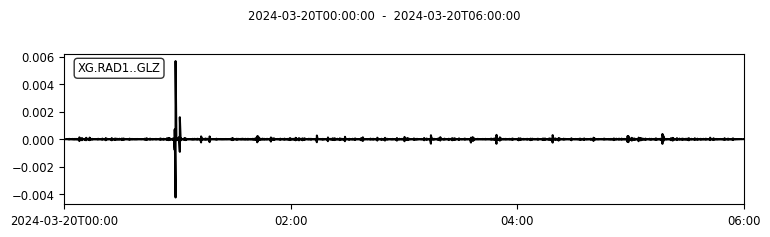

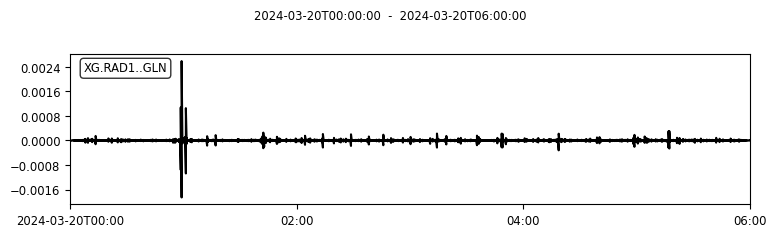

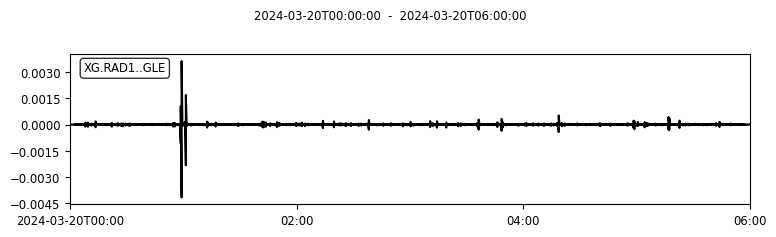

In [4]:
#trim data
t1=UTCDateTime("2024-03-20T00:00:00.00")  
t2=UTCDateTime("2024-03-20T23:00:00.00")
sz2 = sz1.copy()
tr1 = sz2.select(component="Z")[0].trim(t1, t2)
tr2 = sz2.select(component="N")[0].trim(t1, t2)
tr3 = sz2.select(component="E")[0].trim(t1, t2)

tr1.plot()  #raw data
tr2.plot()
tr3.plot()
plt.show()

In [5]:
fl, el =raydec1station(tr1,tr2,tr3,0.2,20,50,10,0.1,100)

54000
nwind 0
start 2024-03-20T00:00:00.000000Z
end 2024-03-20T00:03:36.000000Z
shape after cutting (54001,)
nwind 1
start 2024-03-20T00:03:36.000000Z
end 2024-03-20T00:07:12.000000Z
shape after cutting (54001,)
nwind 2
start 2024-03-20T00:07:12.000000Z
end 2024-03-20T00:10:48.000000Z
shape after cutting (54001,)
nwind 3
start 2024-03-20T00:10:48.000000Z
end 2024-03-20T00:14:24.000000Z
shape after cutting (54001,)
nwind 4
start 2024-03-20T00:14:24.000000Z
end 2024-03-20T00:18:00.000000Z
shape after cutting (54001,)
nwind 5
start 2024-03-20T00:18:00.000000Z
end 2024-03-20T00:21:36.000000Z
shape after cutting (54001,)
nwind 6
start 2024-03-20T00:21:36.000000Z
end 2024-03-20T00:25:12.000000Z
shape after cutting (54001,)
nwind 7
start 2024-03-20T00:25:12.000000Z
end 2024-03-20T00:28:48.000000Z
shape after cutting (54001,)
nwind 8
start 2024-03-20T00:28:48.000000Z
end 2024-03-20T00:32:24.000000Z
shape after cutting (54001,)
nwind 9
start 2024-03-20T00:32:24.000000Z
end 2024-03-20T00:36:00.0

In [6]:
frequency=fl[:,0]
print(np.shape(frequency))

(50,)


In [7]:
ellipticity_mean=[]
for n in range(len(el)):
    vec=el[n,:]
    vec_log=[]
    for i in range(len(vec)):
        vec_log.append(np.log(vec[i]))
    m=np.mean(vec_log)
    ex=np.exp(m)
    ellipticity_mean.append(ex)

In [17]:
from disba import PhaseDispersion
from disba import Ellipticity
import numpy as np
import matplotlib.pyplot as plt

disp_noise_ray=[]  #create Rayleigh wave dispersion curve vector
uncer_ray=[] #create Rayleigh wave uncertainty vector
disp_noise_lov=[]  #create Love wave dispersion curve vector
uncer_lov=[] #create Love wave uncertainty vector
noise_hv=[]  #create HoV curve vector
uncer_hv=[] #create HoV vector
model=np.array([[0.05,1.,0.6,1.8],[0.3,3.6,1.6,2.3],[0.8,6.5,3.8,2.6]]) #create initial list with thickness, Vp, Vs, density
f = np.logspace(-0.7, 1.3, num=100)
t = 1/f
t = np.flip(t)
pd = PhaseDispersion(*model.T)
cpr = pd(t, mode=0, wave="rayleigh")
#cpl = pd(t, mode=0, wave="love")
ell = Ellipticity(*model.T)
rel = ell(t, mode=0)

#plt.plot(1/rel[0],rel[1])
#plt.plot(1/cpr[0],cpr[1],'r')
#plt.title("Dispersion Mode 0")
#plt.show()

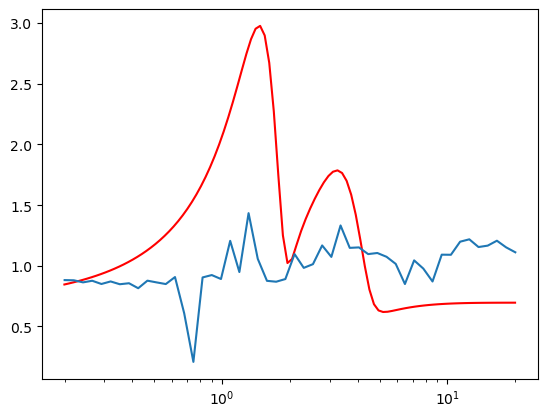

In [18]:
plt.plot(1/rel[0],rel[1],"r")
plt.plot(frequency,ellipticity_mean)
plt.xscale("log")
plt.show()

In [10]:
ellipticity_error=[]
for n in range(len(el)):
    vec=el[n,:]
    vec_log=[]
    for i in range(len(vec)):
        vec_log.append(np.log(vec[i]))
    m=np.std(vec_log)
    ex=np.exp(m)
    ellipticity_error.append(ex)

In [11]:
fp = open("HoV.csv","w")
for i in range(len(frequency)):
    fp.write("%f, %f, %f\n"%(frequency[i],ellipticity_mean[i],ellipticity_error[i]))
fp.close()